In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 2

## Single Layer Perceptron

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com"/>

## Import Statements

In [2]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric

In [3]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input' 
inpDir = Path('..') / '..' / 'input'
# outDir = '../output'
outDir = Path('..') / 'output'


RANDOM_STATE = 24 
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed=RANDOM_STATE)

TEST_SIZE  = 0.2 # Size of test data
NOISE = 0.2
EPOCHS =201
ALPHA = 0.001
N_SAMPLE = 1000

# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
def fn_plot_decision_boundary(X: np.ndarray, wts: np.ndarray, pred_func):
    """
    Plots the decision boundary for a classification model along with the data points.
    
    Args:
        X (np.ndarray): Input feature matrix with shape (n_samples, 3)
        wts (np.ndarray): Weights matrix
        pred_function: Function to predict using weights and datapoints
    """
    
    # Initialize the figure with specified dimensions
    fig, ax = plt.subplots( figsize=(8, 5) )
    
    # Small increment value to create a fine grid for smooth decision boundary
    dm = 0.05
    padding = 2 * dm
    
    # Calculate the range for x-axis (first feature) with padding
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    
    # Calculate the range for y-axis (second feature) with padding  
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding
    
    # Create a mesh grid covering the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # Flatten the mesh grid arrays and stack them column-wise to create coordinate pairs
    XX = np.c_[xx.ravel(), yy.ravel()] # Resulting shape: (n_points, 2)

    # Add a column of ones to the coordinate array for the bias term
    XX = np.hstack((XX, np.ones((XX.shape[0], 1)))) # make array compatible 
    
    # List to collect predictions for each point in the mesh grid
    y_pred = []
    
    # Iterate over each coordinate point in the mesh grid
    for row in XX:
        # Make prediction for the current coordinate using global 'weights' and 'predict' function
        y_p = pred_func(row, wts)
        y_pred.append(y_p)
        
    # Reshape predictions to match the original mesh grid dimensions
    Z = np.array(y_pred).reshape(xx.shape)

    # Create filled contour plot showing the decision regions
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    
    # Scatter plot of the actual data points, colored by their true class labels
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2], s=20, edgecolor='k', cmap=plt.cm.bwr)
    
    # Set plot title and axis labels
    ax.set_title('Decision Boundary')
    ax.set_xlabel('A')  
    ax.set_ylabel('B') 
    
    # Display the final plot
    plt.show()

In [5]:
X, y = make_moons(n_samples=N_SAMPLE, 
                  shuffle=True, 
                  noise=NOISE, 
                  random_state=RANDOM_STATE)
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [6]:
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0]))

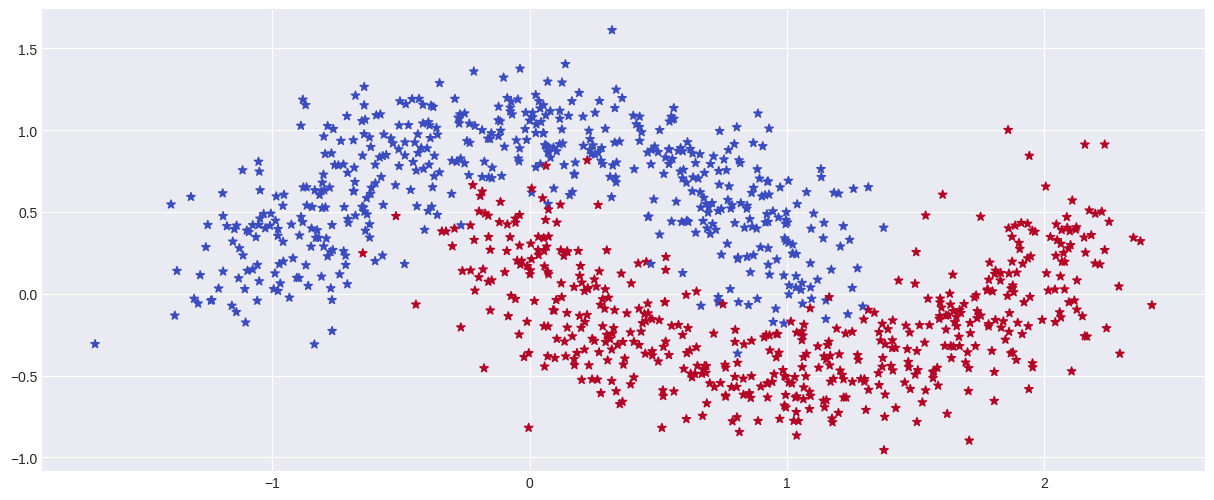

In [7]:
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker='*', cmap=CMAP);

In [8]:
data_df = pd.DataFrame(X, columns =['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [9]:
data_train, data_test = data_df.to_numpy()[:900], data_df.to_numpy()[900:]
data_train.shape, data_test.shape

((900, 3), (100, 3))

In [10]:
def predict(row, weights):
    z = weights[0]
    for i in range(len(row)-1):
        z += weights[i+1]  * row[i]
    return 1 if z >= 0 else 0 # simplest form of activation
    

In [11]:
weights = np.array([0.1, 2.0, 1.0])
predict(data_df.loc[0].to_numpy(), weights)

1

In [12]:
def train_weights(train, alpha, n_epoch):
    error = [] # to track error
    weights = rng.random(train.shape[1]) # initialize weights
    m = train.shape[0] # How many rows
    for epoch in range(n_epoch): # looping for Num Epochs
        sum_error = 0 # to collect error for this 
        for row in train:
            prediction = predict(row, weights)
            dz = prediction - row[-1] # (a-y)
            sum_error += (prediction - row[-1])**2
            weights[0] = weights[0] - alpha * dz
            for i in range(len(row)-1):
                weights[i+1] = weights[i+1] - alpha *dz * row[i]
        error.append(sum_error /m ) # Average error
    return error, weights


In [13]:
error, weights = train_weights(train=data_train, alpha= ALPHA, n_epoch= EPOCHS)
weights

array([-0.00073116,  0.00253448, -0.00399941])

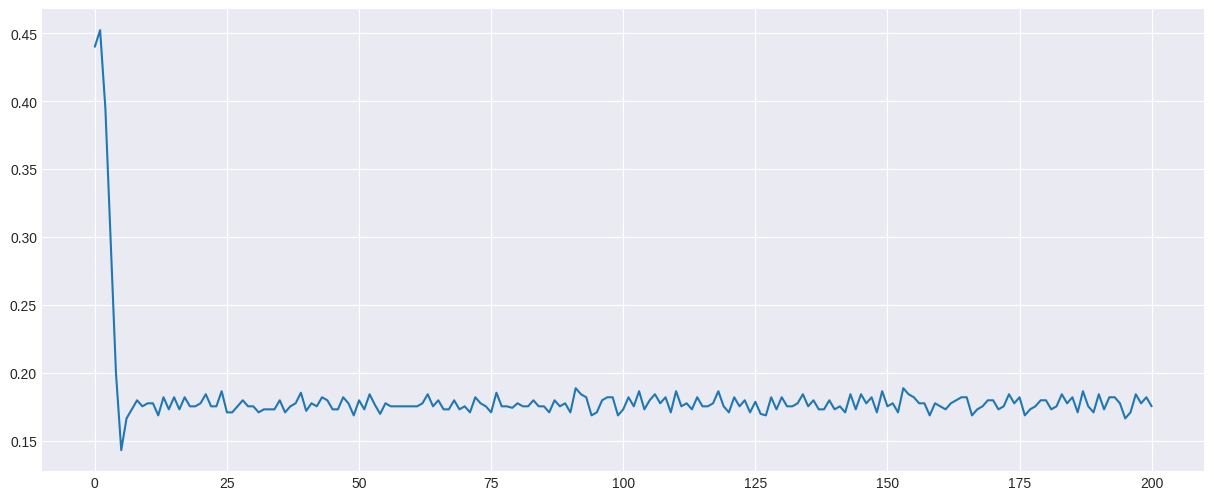

In [14]:
fig, ax = plt.subplots()
ax.plot(error)

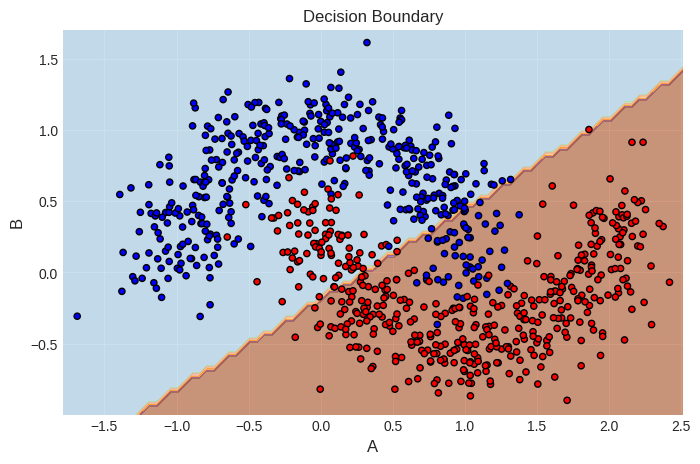

In [39]:
fn_plot_decision_boundary(data_train, weights, predict)

In [ ]:
# # fig, ax= plt.subplots()
# dm = 0.01
# margin = 10*dm
# x_max, x_min = X[:, 0].max() + margin, X[:, 0].min() - margin
# y_max, y_min = X[:, 1].max() + margin, X[:, 1].min() - margin
# xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
#                      np.arange(y_min, y_max, dm))
# X_plot = np.c_[xx.ravel(), yy.ravel()]
# # X_plot = np.hstack((X_plot, np.ones((X_plot.shape[0], 1))))
# # y_pred = []
# # for row in (X_plot):
# #     y_p = predict(row, weights)
# #     y_pred.append(y_p)
# # Z = np.array(y_pred).reshape(xx.shape)
# # ax.contourf(xx, yy, Z, alpha=0.6, cmap=CMAP);
# # ax.scatter(X[:, 0], X[:, 1], c = y, s = 30, edgecolors='k', cmap=plt.cm.bwr);


In [37]:
xx.ravel().shape, X_plot.shape

((119387,), (119387, 2))